In [1]:
import dicom
import os
import numpy
from matplotlib import pyplot, cm
from matplotlib import pylab
from sklearn import datasets, neighbors, linear_model
from skimage.feature import greycomatrix, greycoprops

/Users/ilyas/anaconda/envs/KAMI/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


In [2]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = numpy.random.permutation(len(a))
    return a[p], b[p]

In [50]:
# kind of preprocessing and normalizing dicom images
def load_and_normalize_dicom(path):
    dicom1 = dicom.read_file(path)
    dicom_img = dicom1.pixel_array.astype(numpy.int32)
    mn = dicom_img.min()
    mx = dicom_img.max()
    if (mx - mn) != 0:
        dicom_img = (dicom_img / mx)*255
    else:
        dicom_img[:, :] = 0
    dicom_img = dicom_img.astype(numpy.int32)
    return dicom_img

In [16]:
pathTrainNeg = "./fibrosis_patches_8/train/path"
pathTrainPos = "./fibrosis_patches_8/train/norm"
pathTestNeg = "./fibrosis_patches_8/test/path"
pathTestPos = "./fibrosis_patches_8/test/norm"
lstFilesTrainNeg = []
lstFilesTrainPos = []
lstFilesTestNeg = []
lstFilesTestPos = []
for dirName, subdirList, fileList in os.walk(pathTrainNeg):
    for filename in fileList:
        if ".dcm" in filename.lower():
            lstFilesTrainNeg.append(os.path.join(dirName,filename))
for dirName, subdirList, fileList in os.walk(pathTrainPos):
    for filename in fileList:
        if ".dcm" in filename.lower():
            lstFilesTrainPos.append(os.path.join(dirName,filename))
for dirName, subdirList, fileList in os.walk(pathTestPos):
    for filename in fileList:
        if ".dcm" in filename.lower():
            lstFilesTestPos.append(os.path.join(dirName,filename))
for dirName, subdirList, fileList in os.walk(pathTestNeg):
    for filename in fileList:
        if ".dcm" in filename.lower():
            lstFilesTestNeg.append(os.path.join(dirName,filename))

In [40]:
pos_train=[]
neg_train=[]
X_train=[]
y_train=[]
X_test=[]
y_test=[]
learn_num = 4000
test_num = 2000

for idx,img in enumerate(lstFilesTrainNeg):
    #temp = numpy.ravel(dicom.read_file(img).pixel_array)
    temp = load_and_normalize_dicom(img)
    X_train.append(temp)
    neg_train.append(temp)
    y_train.append(0)
    if idx>learn_num:
        break

for idx,img in enumerate(lstFilesTrainPos):
    #temp = numpy.ravel(dicom.read_file(img).pixel_array)
    temp = load_and_normalize_dicom(img)
    X_train.append(temp)
    pos_train.append(temp)
    y_train.append(1)
    if idx>learn_num:
        break

(X_train, y_train) = unison_shuffled_copies(numpy.asarray(X_train), numpy.asarray(y_train))
for idx,img in enumerate(lstFilesTestNeg):
    #temp = numpy.ravel(dicom.read_file(img).pixel_array)
    temp = load_and_normalize_dicom(img)
    X_test.append(temp)
    y_test.append(0)
    if idx>test_num:
        break
for idx,img in enumerate(lstFilesTestPos):
    #temp = numpy.ravel(dicom.read_file(img).pixel_array)
    temp = load_and_normalize_dicom(img)
    X_test.append(temp)
    y_test.append(1)
    if idx>learn_num:
        break


In [41]:
GLCM_train =[]
GLCM_test =[]
for img in X_train:
    glcm = greycomatrix(img, [2], [0], 256, symmetric=True, normed=True)
    GLCM_train.append([greycoprops(glcm, 'dissimilarity')[0, 0],greycoprops(glcm, 'correlation')[0, 0],greycoprops(glcm, 'homogeneity')[0, 0],greycoprops(glcm, 'contrast')[0, 0]])
for img in X_test:
    glcm = greycomatrix(img, [2], [0], 256, symmetric=True, normed=True)
    GLCM_test.append([greycoprops(glcm, 'dissimilarity')[0, 0],greycoprops(glcm, 'correlation')[0, 0],greycoprops(glcm, 'homogeneity')[0, 0],greycoprops(glcm, 'contrast')[0, 0]])

(array([   0.,    0.,    0.,    0.,    0.,   27.,  322.,  484.,  314.,
         467.,  930.,  703.,  401.,  219.,  100.,   35.,    0.,    0.,    0.]),
 array([  0.        ,   0.52631579,   1.05263158,   1.57894737,
          2.10526316,   2.63157895,   3.15789474,   3.68421053,
          4.21052632,   4.73684211,   5.26315789,   5.78947368,
          6.31578947,   6.84210526,   7.36842105,   7.89473684,
          8.42105263,   8.94736842,   9.47368421,  10.        ]),
 <a list of 19 Patch objects>)

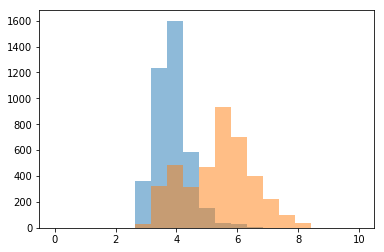

In [60]:
# plotting dissimilarity
%matplotlib inline
pos_list_x = [item[0] for idx,item in enumerate(GLCM_train) if y_train[idx]==1 ]
neg_list_x = [item[0] for idx,item in enumerate(GLCM_train) if y_train[idx]==0 ]
bins = numpy.linspace(0, 10, 20)
pyplot.hist(pos_list_x,bins,alpha=0.5)
pyplot.hist(neg_list_x,bins,alpha=0.5)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     4.,    10.,    14.,    16.,    32.,   136.,
         1373.,  1772.,   645.]),
 array([ 0.        ,  0.05263158,  0.10526316,  0.15789474,  0.21052632,
         0.26315789,  0.31578947,  0.36842105,  0.42105263,  0.47368421,
         0.52631579,  0.57894737,  0.63157895,  0.68421053,  0.73684211,
         0.78947368,  0.84210526,  0.89473684,  0.94736842,  1.        ]),
 <a list of 19 Patch objects>)

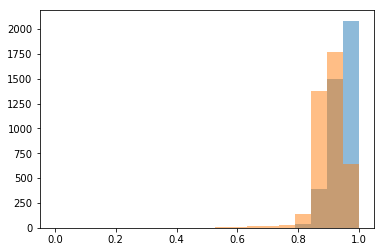

In [59]:
# plotting correlation
%matplotlib inline
pos_list_y = [item[1] for idx,item in enumerate(GLCM_train) if y_train[idx]==1 ]
neg_list_y = [item[1] for idx,item in enumerate(GLCM_train) if y_train[idx]==0 ]
bins = numpy.linspace(0, 1, 20)
pyplot.hist(pos_list_y,bins,alpha=0.5)
pyplot.hist(neg_list_y,bins,alpha=0.5)

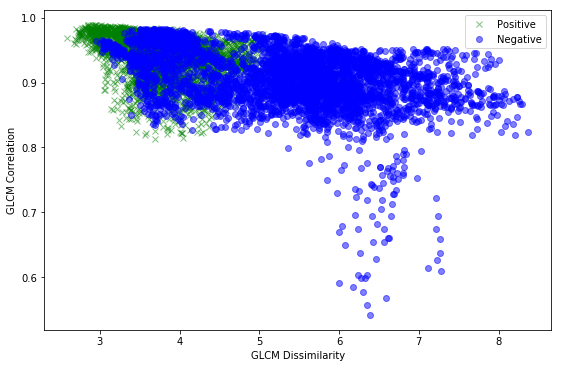

In [49]:
fig = pyplot.figure(figsize=(20, 20))
ax = fig.add_subplot(3, 2, 2)
ax.plot(pos_list_x, pos_list_y, 'gx',
        label='Positive',alpha=0.5)
ax.plot(neg_list_x, neg_list_y, 'bo',
        label='Negative',alpha=0.5)
ax.set_xlabel('GLCM Dissimilarity')
ax.set_ylabel('GLCM Correlation')
ax.legend()

In [45]:
knn = neighbors.KNeighborsClassifier()
logistic = linear_model.LogisticRegression()

print('KNN score: %f' % knn.fit(GLCM_train, y_train).score(GLCM_test, y_test))
print('LogisticRegression score: %f'
      % logistic.fit(GLCM_train, y_train).score(GLCM_test, y_test))

KNN score: 0.666334
LogisticRegression score: 0.749251
